# Differentiation using Trispectral

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import trispectral as ts

In [2]:
cwd = os.path.abspath("")

plt.style.use(os.path.join(cwd, "../misc/mpl_styles/main.mplstyle"))

## Non-periodic domains

Let us introduce a square Chebyshev-Chebyshev grid.

In [3]:
nx = ny = 41

grid = ts.Grid.from_bounds(
    [-2., 2., nx], [-2., 2., ny], discs=["chebyshev"] * 2
)

x, y = grid

We then create a simple scalar grid function $f\left( x,y \right) = xe^{-\left( x^2 + y^2 \right)}$.

In [4]:
f = x * np.exp(-x**2 - y**2)

To compute the gradient field of $f$, we simply run:

In [5]:
g = ts.gradient_operator(grid) @ f

This yields a vector grid field. Now, let's extract its $x$ and $y$ components.

In [6]:
gx, gy = g[: nx * ny], g[nx * ny :]

And plot the resulting vector field `g`.

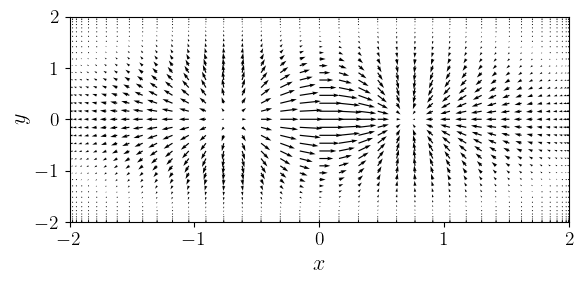

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax.quiver(
    x.reshape(nx, ny, order="F"),
    y.reshape(nx, ny, order="F"),
    gx.reshape(nx, ny, order="F"),
    gy.reshape(nx, ny, order="F"),
    scale=20,
)

ax.set_xticks(np.arange(-2, 3, 1))
ax.set_yticks(np.arange(-2, 3, 1));

# plt.savefig("ex_1.pdf");

To verify that the computed `g` coincides with the exact values, we can perform some assert checks.

In [8]:
assert np.allclose(gx - np.exp(-x**2 - y**2) + 2 * x * f, 0)
assert np.allclose(gy + 2 * y * f, 0)

Now, let us evaluate the divergence of `g`.

In [9]:
d = ts.divergence_operator(grid) @ g

This is analogous to computing the Laplacian of `f`.

In [10]:
sl = ts.scalar_laplacian_operator(grid) @ f

Check that `sl` and `d` coincide and that `sl` coincides with the exact value.

In [11]:
assert np.allclose(d, sl)
assert np.allclose(sl + 8 * f - 4 * (x**2 + y**2) * f, 0)

Graphically, $\nabla^2 f$ can be represented as follows:

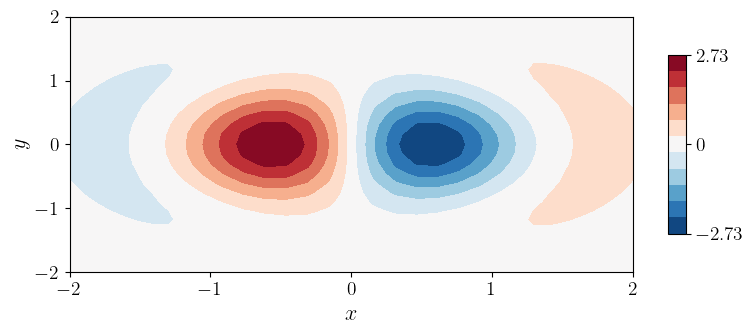

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), tight_layout=True)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

c = ax.contourf(
    x.reshape(nx, ny, order="F"),
    y.reshape(nx, ny, order="F"),
    sl.reshape(nx, ny, order="F"),
    levels=np.linspace(np.min(sl), np.max(sl), 12),
    cmap=plt.get_cmap("RdBu_r"),
)

cbar = plt.colorbar(
    c,
    ax=ax,
    ticks=[np.min(sl), 0, np.max(sl)],
    location="right",
    shrink=0.7,
    aspect=10,
)
cbar.ax.set_yticklabels([f"${np.min(sl): .2f}$", 0, f"${np.max(sl): .2f}$"])


ax.set_xticks(np.arange(-2, 3, 1))
ax.set_yticks(np.arange(-2, 3, 1));

# plt.savefig("ex_2.pdf");

To compute the Laplacian of a vector field, we must use `vector_laplacian_operator` function. Let us evaluate the Laplacian of `g`.

In [13]:
vl = ts.vector_laplacian_operator(grid) @ g
vlx, vly = vl[: nx * ny], vl[nx * ny :]

In [14]:
assert np.allclose(vlx, ts.scalar_laplacian_operator(grid) @ gx)
assert np.allclose(vly, ts.scalar_laplacian_operator(grid) @ gy)

To compute the curl of a 3D vector field, we use `curl_operator` function. Consider the following 3D function:

$f\left( x, y, z \right) = \cos{\left( x + y \right)} - \sin{\left( z - y \right)}$.

Its gradient $\boldsymbol{g} = \nabla f$ is given by:

$\boldsymbol{g}\left( x, y, z \right) = -\sin{\left( x + y \right)}\boldsymbol{1}_x + \left[ -\sin{\left( x + y \right)} + \cos{\left( z - y \right)} \right]\boldsymbol{1}_y - \cos{\left( z - y \right)}\boldsymbol{1}_z$.

We then introduce a 3D grid.

In [15]:
nx = ny = nz = 21

grid = ts.Grid.from_bounds(
    [-np.pi / 2, np.pi / 2, nx],
    [-np.pi / 2, np.pi / 2, ny],
    [-np.pi / 2, np.pi / 2, nz],
    discs=3 * ["chebyshev"],
)
x, y, z = grid

And compute its curl as follows:

In [16]:
u = np.concatenate(
    [
        -np.sin(x + y),
        -np.sin(x + y) + np.cos(z - y),
        -np.cos(z - y),
    ]
)

In [17]:
c = ts.curl_operator(grid) @ u

We then verify that the resulting field is 0 everywhere (as the curl of the gradient is always zero).

In [18]:
assert np.allclose(c, 0)

## Domains with periodic directions

In the case of domain with one or multiple periodic directions, no additional care needs to be taken when computing derivatives. Consider the following 2D periodic grid:

In [19]:
nx = ny = 32

grid = ts.Grid.from_bounds(
    [-np.pi, np.pi - 2.0 * np.pi / nx, nx],
    [-np.pi, np.pi - 2.0 * np.pi / ny, ny],
    discs=["periodic"] * 2,
)
x, y = grid

We create a simple periodic function.

In [20]:
f = np.sin(3 * x) * np.cos(y)

And then compute its gradient.

In [21]:
g = ts.gradient_operator(grid) @ f
gx, gy = g[: nx * ny], g[nx * ny :]

In [22]:
assert np.allclose(gx - 3 * np.cos(3 * x) * np.cos(y), 0)
assert np.allclose(gy + np.sin(3 * x) * np.sin(y), 0)

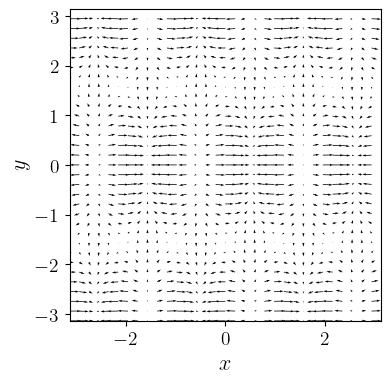

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)

ax.set_aspect(1)

ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

X = x.reshape(nx, ny, order="F")
Y = y.reshape(nx, ny, order="F")
GX = gx.reshape(nx, ny, order="F")
GY = gy.reshape(nx, ny, order="F")

X = np.vstack([X, -X[0]])
Y = np.vstack([Y, -Y[0]])
GX = np.vstack([GX, GX[0]])
GY = np.vstack([GY, GY[0]])

ax.quiver(x, y, gx, gy);

# plt.savefig("ex_3.pdf");

Similarly, consider the case of one periodic and one non-periodic dimensions:

In [24]:
nx = 41
ny = 28

grid = ts.Grid.from_bounds(
    [0., 2., nx],
    [-np.pi, np.pi - 2.0 * np.pi / ny, ny],
    discs=["chebyshev", "periodic"],
)
x, y = grid

And the 2D vector function:

In [25]:
u = np.concatenate(
    [x * np.sinh(x) * np.sin(y), np.cosh(x) * np.cos(y)]
)

We then compute its divergence:

In [26]:
d = ts.divergence_operator(grid) @ u

In [27]:
assert np.allclose(
    d
    - np.sinh(x) * np.sin(y)
    - x * np.cosh(x) * np.sin(y)
    + np.cosh(x) * np.sin(y),
    0,
)

## Polar geometry

In [3]:
nphi, nr = 20, 31

grid = ts.Grid.polar(nphi, nr)

phi, r = grid[:, grid[1] > 0]

In [4]:
f = 1 - r**2

In [5]:
g = ts.gradient_operator(grid) @ f

gphi, gr = g[: nphi * nr], g[nphi * nr :]

In [6]:
assert np.allclose(gphi, 0)
assert np.allclose(gr, -2 * r)

In [7]:
d = ts.divergence_operator(grid) @ g

In [8]:
assert np.allclose(d, -4)

In [9]:
sl = ts.scalar_laplacian_operator(grid) @ f

In [10]:
assert np.allclose(sl, d)

In [13]:
wavevector = [0, None], [1, None], 0.

u = np.concatenate([np.zeros(2 * nphi * nr), f])

In [14]:
vl = ts.vector_laplacian_operator(grid, wavevector=wavevector) @ u

In [19]:
assert np.allclose(vl[: 2 * nphi * nr], 0)
assert np.allclose(vl[2 * nphi * nr :], sl)

In [20]:
v = np.concatenate([-np.sin(phi), np.cos(phi), np.zeros(nphi * nr)])

In [23]:
a = ts.directional_derivative_operator(
    grid, a=u, wavevector=wavevector
) @ v

In [24]:
assert np.allclose(a, 0)

In [25]:
b = ts.directional_derivative_operator(
    grid, a=v, wavevector=wavevector
) @ u

In [27]:
assert np.allclose(b[: 2 * nphi * nr], 0)
assert np.allclose(b[2 * nphi * nr :], -2 * r * np.cos(phi))

## 2. Divergence

### 2.2 3D Cartesian case with two homogeneous directions

Consider a 3D domain with homogeneous $x$ and $z$ directions, such that

$f\left( x, y, z \right) = \hat{f}\left( y \right)e^{i\alpha x + i\beta z}$,

the Laplacian is given by:

$\nabla^2 f = e^{i\alpha x + i\beta z} \left( \hat{f}'' - \alpha^2 - \beta^2 \right)$.

In [2]:
alpha = 1.
beta = 2.
wavevector = alpha, [0, None], beta

In [3]:
ny = 41

grid = ts.Grid.from_bounds([-1., 1., ny], discs=["chebyshev"])
y = grid[0]

In [5]:
ux, uy, uz = np.cos(y**2), 1 - y, np.sin(y**2)
u = np.concatenate([ux, uy, uz])

dhat = ts.divergence_operator(grid, wavevector=wavevector) @ u

In [7]:
assert np.allclose(
    dhat - 1j * alpha * ux + np.ones_like(y) - 1j * beta * uz, 0
)

## 3. Laplace operator

### 3.1 Laplacian of a scalar field in 3D Cartesian case

Consider a scalar 3D function:

$f \left( x,y,z \right) = \cos{\left( x + y \right)} - \sin{\left( z - y \right)}$.

Its Laplacian is given by $\nabla^2 f = -2f$.

In [3]:
nx = ny = nz = 31

grid = ts.Grid.from_bounds(
    [0., 2., nx], [0., 2., ny], [0., 2., nz], discs=3 * ["chebyshev"]
)
x, y, z = grid

In [4]:
f = np.cos(x + y) - np.sin(z - y)

l = ts.scalar_laplacian_operator(grid) @ f

In [5]:
assert np.allclose(l + 2 * f, 0)

### 3.1 Laplacian of a scalar field in 3D Cartesian case with two homogeneous directions

For the function of the following form:

$f\left( x, y, z \right) = \hat{f}\left( y \right)e^{i\alpha x + i\beta z}$,

the Laplacian is given by:

$\nabla^2 f = e^{i\alpha x + i\beta z} \left( \hat{f}'' - \alpha^2 - \beta^2 \right)$.

In [11]:
alpha = 1.
beta = 2.
wavevector = alpha, [0, None], beta

In [12]:
ny = 41

grid = ts.Grid.from_bounds([-1., 1., ny], discs=["chebyshev"])
y = grid[0]

In [16]:
fhat = np.exp(-6 * y**2)

lhat = ts.scalar_laplacian_operator(grid, wavevector=wavevector) @ fhat

In [17]:
assert np.allclose(
    (
        lhat
        - 12 * fhat * (12 * y**2 - 1)
        + alpha**2 * fhat
        + beta**2 * fhat
    ),
    0,
)

### 3.1 Laplacian of a vector field in 3D Cartesian case

$\boldsymbol{u} = 3x^2 y\boldsymbol{1}_x + \sin{(xyz)}\boldsymbol{1}_y + (z^3 - yz)\boldsymbol{1}_z$.

$\nabla^2 \boldsymbol{u} = 6y\boldsymbol{1}_x - 3\sin{(xyz)\boldsymbol{1}_y + 6z\boldsymbol{1}_z}$.

In [4]:
nx = ny = 41

grid = ts.Grid.from_bounds(
    [-np.pi, np.pi, nx],
    [-np.pi, np.pi, ny],
    discs=2 * ["chebyshev"],
)
x, y = grid

In [5]:
u = np.concatenate([3 * x**2 * y, np.sin(x * y)])

l = ts.vector_laplacian_operator(grid) @ u

In [6]:
lx, ly = l[: nx * ny], l[nx * ny :]

In [10]:
assert np.allclose(lx - 6 * y, 0)
assert np.allclose(ly + (x**2 + y**2) * np.sin(x * y), 0)

## Directional derivative

In [2]:
nx = ny = 41

grid = ts.Grid.from_bounds(
    [-1., 1., nx],
    [-1., 1., ny],
    discs=2 * ["chebyshev"],
)
x, y = grid

In [3]:
a = np.concatenate([x + y, x - y])
b = np.concatenate([np.cos(x**2 + y**2), np.sin(x**2 + y**2)])

In [4]:
da = ts.directional_derivative_operator(grid, a=a) @ b
dax, day = da[: nx * ny], da[nx * ny :]

In [5]:
db = ts.directional_derivative_operator(grid, b=b) @ a
dbx, dby = db[: nx * ny], db[nx * ny :]

In [6]:
assert np.allclose(
    dax + 2 * np.sin(x**2 + y**2) * (x**2 - y**2 + 2 * x * y), 0
)
assert np.allclose(
    dbx + 2 * np.sin(x**2 + y**2) * (x**2 - y**2 + 2 * x * y), 0
)
assert np.allclose(
    day - 2 * np.cos(x**2 + y**2) * (x**2 - y**2 + 2 * x * y), 0
)
assert np.allclose(
    dby - 2 * np.cos(x**2 + y**2) * (x**2 - y**2 + 2 * x * y), 0
)